# Fake News Detection Using Machine Learning

### Summary:

Fake news refers to deliberately false or misleading information spread to deceive people. It often spreads rapidly, especially on social media, and can have significant real-world consequences.

In real life, critical thinking, fact-checking, and reliable news sources are essential tools to combat the spread and impact of fake news.

The goal is to help users differentiate between trustworthy and misleading content, combating misinformation effectively.

I shall be using Random Forest classifier from sklearn for Fake news detection model.

### Importing all the necessary libraries

In [3]:
import numpy as np
import pandas as pd

# for cleaning text
import re
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# for vectorizing text and spliting the data into train and test 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# for random forest classifier
from sklearn.ensemble import RandomForestClassifier

# for getting accuracy and report
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

#for graph ploting
import matplotlib.pyplot as plt
import seaborn as sns

### Data Collection

* Collecting data from the source (More info below).
* Merge it into single dataset.
* Remove unnecessary data that are not required.


### Data Source

I shall be using the dataset that is available on kaggle provided by Emine Bozkus.

Source: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets

In [5]:
df_fake = pd.read_csv("archive (2)/News _dataset/Fake.csv")
df_true = pd.read_csv("archive (2)/News _dataset/True.csv")

In [7]:
print(df_true['title'][0])
print(df_true['text'][0])
print("==========================")
print(df_fake['title'][0])
print(df_fake['text'][0])

As U.S. budget fight looms, Republicans flip their fiscal script
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

In [9]:
# since there is no indication of status of real and fake news, 
# I shall give new indication, 0 shall represent that the news is fake and 1 shall represent that news is real

df_fake['status'] = 0
df_true['status'] = 1

df = pd.concat([df_fake, df_true])
df.drop(['subject', 'date'], inplace=True, axis=1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   status  44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [19]:
df.isna().sum()

title     0
text      0
status    0
dtype: int64

#### Since there are no NULL or empty values we can go to next step

In [22]:
# Since the data is not blended properly, we shall shuffle the data
random_index = np.random.randint(0,len(df),len(df))
df = df.iloc[random_index].reset_index(drop=True)

In [24]:
df.head()

,title,text,status
0,Caribbean faces hard road to recovery after Ir...,"VARADERO, Cuba (Reuters) - From Cuba to Antigu...",1
1,PAUL JOSEPH WATSON Exposes Media’s Obsession W...,Here was Trump s epic response to the leftist ...,0
2,Kerry trip to Cuba for rights dialogue cancele...,WASHINGTON (Reuters) - Tentative plans for U.S...,1
3,MASSIVE MI VOTER FRAUD UNCOVERED? 59% Of Detro...,One-third of precincts in Wayne County could b...,0
4,“Not a word”…That’s What The Parents Of Beauti...,"Kate Steinle is the wrong race, and she was k...",0


### Data Cleaning

From both Title and Content-
* Split the data.
* Remove all the stop words and special characters ((),.><$@/?"''"\][\|!*-{}^%#+).
* Lemmatization of the words.
* And join the data back again for next stage.

From the Title-
* Removing the reuter tag and state's name

I will be using nltk library to achieve this step

In [27]:
#Download all necessary NLTK data files
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

def get_wordnet_pos(tag):    
    # Maps POS tag to the first character for WordNetLemmatizer.
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Perform POS tagging
    pos_tags = nltk.pos_tag(tokens)
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags
    ]
    
    # Rejoin tokens into a single string
    return ' '.join(lemmatized_tokens)


def preprocess_title(text):
    # Remove special characters and numbers for both Title and Text
    text = re.sub(r'[^a-zA-Z\s]', '', text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    return preprocess_text(text)

def preprocess_content(text):
    # Remove URLs from text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    #To remove "Reuters - State/Location Name" or standalone "Reuters" from the Text
    # text = re.sub(r'\bReuters\b(?:\s*-\s*[A-Za-z\s]+)?', '', text).strip()

    #if the state names comes first then the reuter tag
    text = re.sub(r'\b[A-Za-z\s]+\s*\(Reuters\)|\(Reuters\)', '', text)
    
    #to Remove special characters and numbers for both Title and Text
    text = re.sub(r'[^a-zA-Z\s]', '', text).strip()
    
    #to Convert to lowercase
    text = text.lower()

    return preprocess_text(text)


#  testing
# if __name__ == "__main__":
#     sample_text = """
#     Breaking news: Government plans to reduce taxes next year!
#     Visit https://news.example.com for more details.
#     """
#     clean_text = preprocess_text(sample_text)
#     print("Original Text:", sample_text)
#     print("Processed Text:", clean_text)

[nltk_data] Downloading package punkt_tab to C:\Users\SAYYAM
[nltk_data]     NAHAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\SAYYAM
[nltk_data]     NAHAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\SAYYAM NAHAR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\SAYYAM
[nltk_data]     NAHAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
#to apply above functions for converting text (takes 10 min of execution time)
df['title'] = df['title'].apply(preprocess_title)
df['text'] = df['text'].apply(preprocess_content)

#### Combine title and text into single column

In [31]:
df['combined_text'] = df['title'] + " " + df['text']

In [33]:
df.head()

,title,text,status,combined_text
0,caribbean face hard road recovery irmas ravage,varadero cuba antigua caribbean islander begin...,1,caribbean face hard road recovery irmas ravage...
1,paul joseph watson expose medias obsession tru...,trump epic response leftist mediainteresting u...,0,paul joseph watson expose medias obsession tru...
2,kerry trip cuba right dialogue cancel u official,tentative plan u secretary state john kerry vi...,1,kerry trip cuba right dialogue cancel u offici...
3,massive mi voter fraud uncover detroit vote co...,onethird precinct wayne county could disqualif...,0,massive mi voter fraud uncover detroit vote co...
4,wordthats parent beautiful young woman murder ...,kate steinle wrong race kill someone obama adv...,0,wordthats parent beautiful young woman murder ...


#### We shall split the data into train and test data using train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df['combined_text'], df['status'], 
    test_size = 0.2, 
    random_state = 42
)

#### Now we shall to convert categorical data into numerical data for our model to understand and train upon it

In [39]:
# max_length = max(df['combined_text'].map(len))
vectorize = TfidfVectorizer(max_features=10000)

X_train_Tfid = vectorize.fit_transform(X_train)
X_test_Tfid = vectorize.transform(X_test)

### Random Forest Classifier

In [139]:
model = RandomForestClassifier()
model.fit(X_train_Tfid, y_train)

RandomForestClassifier()

In [141]:
y_pred = model.predict(X_test_Tfid)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix =  confusion_matrix(y_test, y_pred)

# for roc auc score
# y_prob = model.predict_proba(X_test_Tfid)
# roc_score = roc_auc_score(y_test, y_prob)

print("Accuracy= ", accuracy)
print("Classification Report=\n ", report)
# print("Confusion Matrix=\n ", matrix)

Accuracy=  0.9897550111358575
Classification Report=
                precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



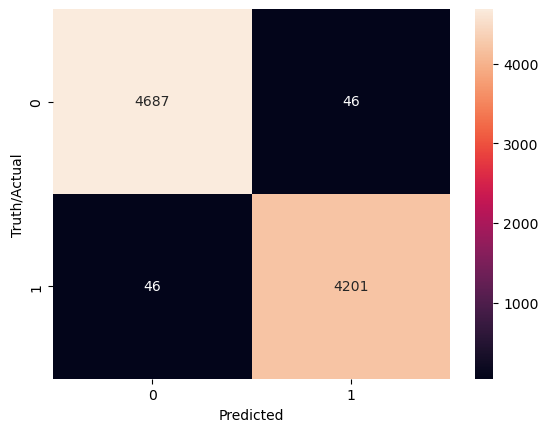

In [143]:
sns.heatmap(matrix, annot = True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth/Actual')
plt.show()

#### Test

Since the model has been trained and tested, I shall now conduct a simple test on the model by passing 2 news articles(1 real and another one being fake) to test models accuracy.

In [145]:
# real news
data_1 = pd.DataFrame({
    "title": ["Trump says Microsoft's Bill Gates has asked to visit him in Florida"],
    "text": [
        "Donald Trump said Microsoft, opens new tab co-founder Bill Gates has asked to visit him at the president-elects Mar-a-Lago home in Florida on Friday night. Part way through a Truth Social post on Friday morning, Trump referred to his Mar-a-Lago home, saying Bill Gates asked to come, tonight. We miss you and x! New Year Eve is going to be AMAZING!!! DJT. Trump provided no further details. Emails and calls to the Bill & Melinda Gates Foundation asking about a potential Gates visit to Mar-a-Lago were not immediately answered. Gates has been critical of Trump in the past, particularly over his first administrations response to the COVID-19 pandemic, but Gates publicly congratulated Trump on his Nov. 5 election victory and expressed hope they could work together. Some of the biggest tech sector companies in the U.S. have pledged donations to Trumps inaugural fund as they seek more favorable relations with the Republican president-elect before he takes office on Jan. 20. In November, Meta Platforms, opens new tab CEO Mark Zuckerberg visited Trump at Mar-a-Lago. Meta has donated $1 million to Trumps inaugural fund, a company spokesperson told Reuters on Dec. 12. Other tech companies that are donating $1 million to Trumps inaugural fund include Amazon, opens new tab and Uber Technologies"
    ]
})

# fake news
data_2 = pd.DataFrame({
    "title": ["‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens"],
    "text": [
         "In the hours following a violent rampage in Wisconsin in which a lone attacker killed at least two individuals and injured six others, citizens living in the only country where this kind of mass killing routinely occurs reportedly concluded Monday that there was no way to prevent the massacre from taking place. “This was a terrible tragedy, but sometimes these things just happen and there’s nothing anyone can do to stop them,” said Maryland resident Jonathan Pallard, echoing sentiments expressed by tens of millions of individuals who reside in a nation where over half of the world’s deadliest mass shootings have occurred in the past 50 years and whose citizens are 20 times more likely to die of gun violence than those of other developed nations. “It’s a shame, but what can we do? There really wasn’t anything that was going to keep this individual from snapping and killing a lot of people if that’s what they really wanted.” At press time, residents of the only economically advanced nation in the world where roughly two mass shootings have occurred every month for the past eight years were referring to themselves and their situation as “helpless."
    ]
})

data_1['combined'] = data_1['title'].apply(preprocess_title) + " " + data_1['text'].apply(preprocess_content)  #real news
data_2['combined'] = data_2['title'].apply(preprocess_title) + " " + data_2['text'].apply(preprocess_content)  #fake news
 
X_real = vectorize.transform(data_1['combined'])
X_fake = vectorize.transform(data_2['combined'])

def test_model(X_test_vect):
    y_test_pred = model.predict(X_test_vect)
    # print(y_test_pred.shape)
    # print(y_test_pred)
    predicted_label = round(y_test_pred[0])  # Assuming model outputs probabilities
    if predicted_label == 0:
        print("News is fake")
    elif predicted_label == 1:
        print("News is real")
    else:
        print("Unexpected prediction:", y_test_pred[0])

print("For first news")
test_model(X_real)
print("For second news")
test_model(X_fake)

For first news
News is real
For second news
News is fake


### Conclusion

The Fake News Detection System demonstrated exceptional performance with an accuracy of 99.05% on the test dataset. The classification report further highlights the model's effectiveness, achieving high precision, recall, and F1-scores for both real news (label 1) and fake news (label 0).   

This high level of accuracy and robust classification metrics suggest that the system is highly reliable for distinguishing between real and fake news. However, further testing on unseen and diverse datasets is recommended to validate generalizability and ensure the system's effectiveness in real-world scenarios.